In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from multiprocessing import Pool
from tqdm.notebook import trange
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
source_data_dir = "../../source_data"
prjDir = "../../../simulation"
scRefA = sc.read_h5ad(f"{source_data_dir}/PDACA_single_cell_filtered_meta_cell_types.h5")

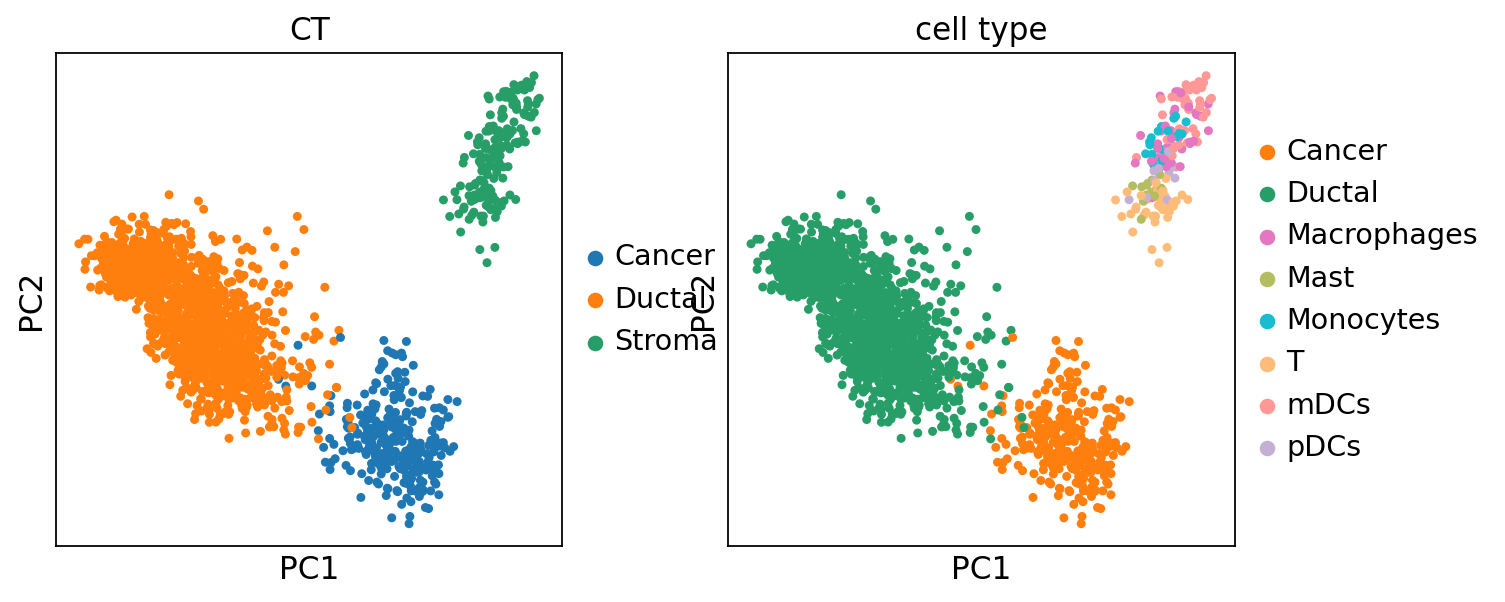

In [3]:
sc.set_figure_params({'fig.size': (5,4)})
sc.pl.pca(scRefA,color=['CT', 'cell type'])

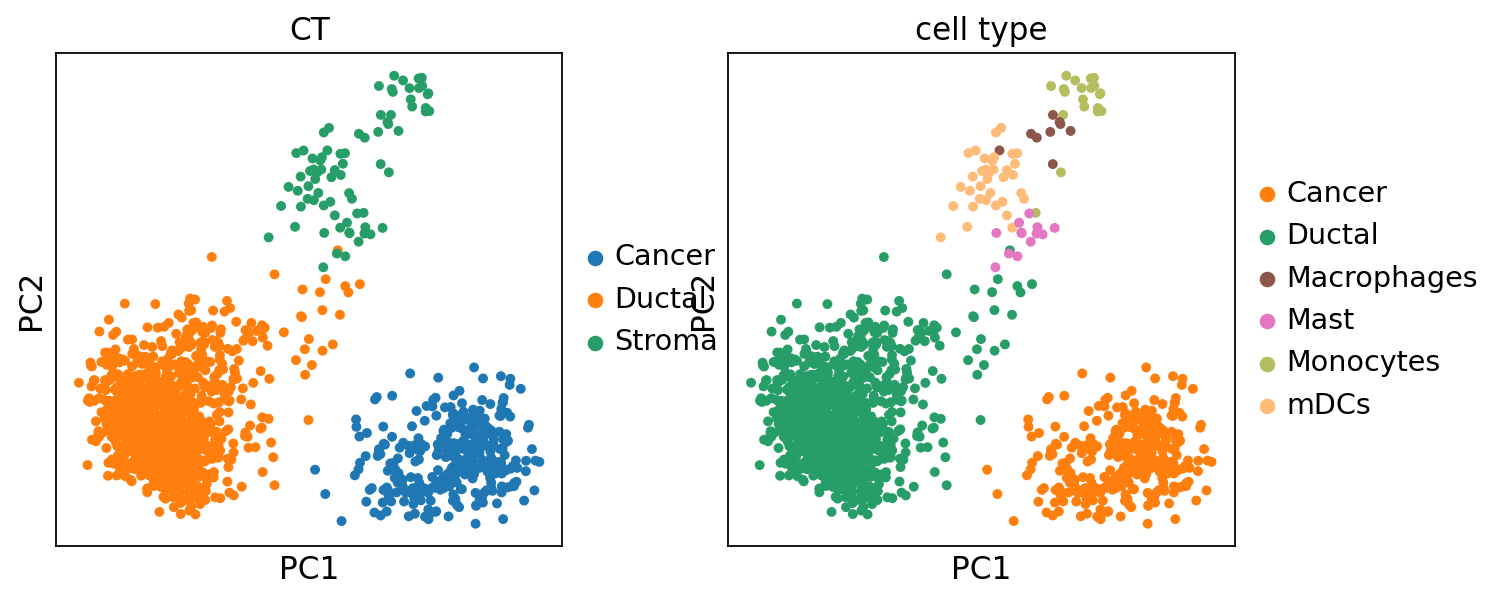

In [4]:
scRefB = sc.read_h5ad(f"{source_data_dir}/PDACB_single_cell_filtered_meta_cell_types.h5")
sc.tl.pca(scRefB)
sc.pl.pca(scRefB, color=['CT', 'cell type'])

In [5]:
set(scRefA.obs['cell type'])  - set(scRefB.obs['cell type']) 

{'T', 'pDCs'}

In [6]:
scRefA_filt = scRefA[~scRefA.obs['cell type'].isin(['T', 'pDCs']), ]
set(scRefA_filt.obs['cell type']), set(scRefB.obs['cell type']) 

({'Cancer', 'Ductal', 'Macrophages', 'Mast', 'Monocytes', 'mDCs'},
 {'Cancer', 'Ductal', 'Macrophages', 'Mast', 'Monocytes', 'mDCs'})

In [7]:
scRefA_raw = scRefA_filt.raw.to_adata()
scRefA_ref_count = pd.DataFrame(data=scRefA_raw.X, index=scRefA_raw.obs.index, columns=scRefA_raw.var.index)
scRefA_ref_count.columns.name=None

scRefA_ref_meta = scRefA_raw.obs[['CT']]
scRefA_ref_meta.columns=[['bio_celltype']]
assert (scRefA_ref_count.index == scRefA_ref_meta.index).all()

scRefA_ref_count.to_csv(f'{prjDir}/reference/primary/Internal/count.csv')
scRefA_ref_meta.to_csv(f'{prjDir}/reference/primary/Internal/meta.csv')

scRefA_ref_count.to_csv(f'{prjDir}/reference/primary/Internal/count.tsv', sep='\t')
scRefA_ref_meta.to_csv(f'{prjDir}/reference/primary/Internal/meta.tsv', sep='\t')

In [8]:
scRefA_ref_meta_secondary = scRefA_raw.obs[['cell type']]
scRefA_ref_meta_secondary.columns=[['bio_celltype']]
assert (scRefA_ref_count.index == scRefA_ref_meta_secondary.index).all()

scRefA_ref_count.to_csv(f'{prjDir}/reference/secondary/Internal/count.csv')
scRefA_ref_meta_secondary.to_csv(f'{prjDir}/reference/secondary/Internal/meta.csv')

scRefA_ref_count.to_csv(f'{prjDir}/reference/secondary/Internal/count.tsv', sep='\t')
scRefA_ref_meta_secondary.to_csv(f'{prjDir}/reference/secondary/Internal/meta.tsv', sep='\t')

In [9]:
scRefB_raw = scRefB.raw.to_adata()
scRefB_ref_count = pd.DataFrame(data=scRefB_raw.X, index=scRefB_raw.obs.index, columns=scRefB_raw.var.index)
scRefB_ref_count.columns.name=None
scRefB_ref_meta = scRefB_raw.obs[['CT']]
scRefB_ref_meta.columns=[['bio_celltype']]

assert (scRefA_ref_count.index == scRefA_ref_meta.index).all()
scRefB_ref_count.to_csv(f'{prjDir}/reference/primary/External/count.csv')
scRefB_ref_meta.to_csv(f'{prjDir}/reference/primary/External/meta.csv')

scRefB_ref_count.to_csv(f'{prjDir}/reference/primary/External/count.tsv', sep='\t')
scRefB_ref_meta.to_csv(f'{prjDir}/reference/primary/External/meta.tsv', sep='\t')

In [10]:
scRefB_ref_meta_secondary = scRefB_raw.obs[['cell type']]
scRefB_ref_meta_secondary.columns=[['bio_celltype']]

assert (scRefA_ref_count.index == scRefA_ref_meta.index).all()
scRefB_ref_count.to_csv(f'{prjDir}/reference/secondary/External/count.csv')
scRefB_ref_meta_secondary.to_csv(f'{prjDir}/reference/secondary/External/meta.csv')

scRefB_ref_count.to_csv(f'{prjDir}/reference/secondary/External/count.tsv', sep='\t')
scRefB_ref_meta_secondary.to_csv(f'{prjDir}/reference/secondary/External/meta.tsv', sep='\t')

In [11]:
from matplotlib import pyplot as plt
def set_core_regions_circle(A, center, layer, radius, ignore_points = []):
    x0, y0 = center
    core_points = []
    for x in range(x0-radius, x0+radius + 1):
        for y in range(y0-radius, y0+radius+1):
            if np.sqrt(np.square(x - x0) + np.square(y-y0)) <= radius:
                if x < A.shape[0] and y < A.shape[1]:
                    if (x, y) not in ignore_points:
                        A[x, y, layer] = 1
                        core_points.append((x,y))
    return A, core_points

def set_core_regions_rect(A, center, layer, 
                          radius=None, w=None, l=None, ignore_points=[]):
    x0, y0 = center
    core_points = []
    if (w== None) or (l==None):
        assert radius != None
        w = l = radius
        
    for x in range(x0-w//2, x0+w//2 + 1):
        for y in range(y0-l//2, y0+l//2+1):
            if x < A.shape[0] and y < A.shape[1] and x >= 0 and y >=0:
                if (x, y) not in ignore_points:
                    A[x, y, layer] = 1
                    core_points.append((x,y))
    return A, core_points

def assign_proportions_to_point(point, core_regions, random_state=0):
    distances = []
    for core_region in core_regions:
        min_dist = 1000
        for core_point in core_region:
            core_point = core_point[:2]
            dist = np.linalg.norm(np.array(point)-np.array(core_point))
            if dist < min_dist:
                min_dist = dist
        distances.append(min_dist)
    affinities = 1/ np.array(distances)
    proportions = affinities/np.sum(affinities)
    # add some random noise
    return proportions

In [12]:
def simulate_sample(center_r, rr, center_g, rg, center_b, rb):
    mat = np.zeros((50, 50, 3))
    mat, center_points_r = set_core_regions_circle(mat, center_r, 0, rr,)
    mat, center_points_g = set_core_regions_rect(mat, center_g, 1, w=rg, l=int(rg*2.5), 
                                                   ignore_points=center_points_r)
    mat, center_points_b = set_core_regions_circle(mat, center_b, 2, rb,
                                                  ignore_points=center_points_r + center_points_g)
    center_points = center_points_r + center_points_g + center_points_b
    simulated_meta = []
    
    seed = 0
    for x in trange(50):
        for y in range(50):
            point = (x,y)
            if point not in center_points:
                proportions = assign_proportions_to_point(point, 
                            [center_points_r , center_points_g , center_points_b])
                # add random noise to proportions
                np.random.seed(2022 - seed)
                rand1 = np.random.choice([0, 0.1, 0.2], 3, p = [0.4, 0.4, 0.2], replace=True) 
                proportions = proportions + rand1
                proportions = proportions/np.sum(proportions)
                seed += 1
            else:
                proportions = mat[x, y]
            mat[x,y] = proportions
            r, g, b = proportions[0], proportions[1], proportions[2]
            idx = f'{x}x{y}'
            df = pd.DataFrame(data=[[r,g,b]], columns=['Cancer', 'Ductal', 'Stroma'], index=[idx])
            df = (df * 10).astype(int)
            simulated_meta.append(df)

    simulated_meta = pd.concat(simulated_meta)
    #simulated_meta.to_csv(f"{prjDir}/simulated_data/pure/simulated_spot_counts_ground_truth.csv")
    simulated_meta_props = simulated_meta.divide(simulated_meta.sum(axis=1), axis=0)
    #simulated_meta_props.to_csv(f"{prjDir}/simulated_data/pure/simulated_spot_props_ground_truth.csv")
    return simulated_meta, mat

center_r, rr = (10,10), 9 # define center of red
center_g, rg = (40, 30), 10 # define center green
center_b, rb = (20, 30), 8 # define center of blue
simulated_meta1, mat1 = simulate_sample(center_r, rr, center_g, rg, center_b, rb)

  0%|          | 0/50 [00:00<?, ?it/s]

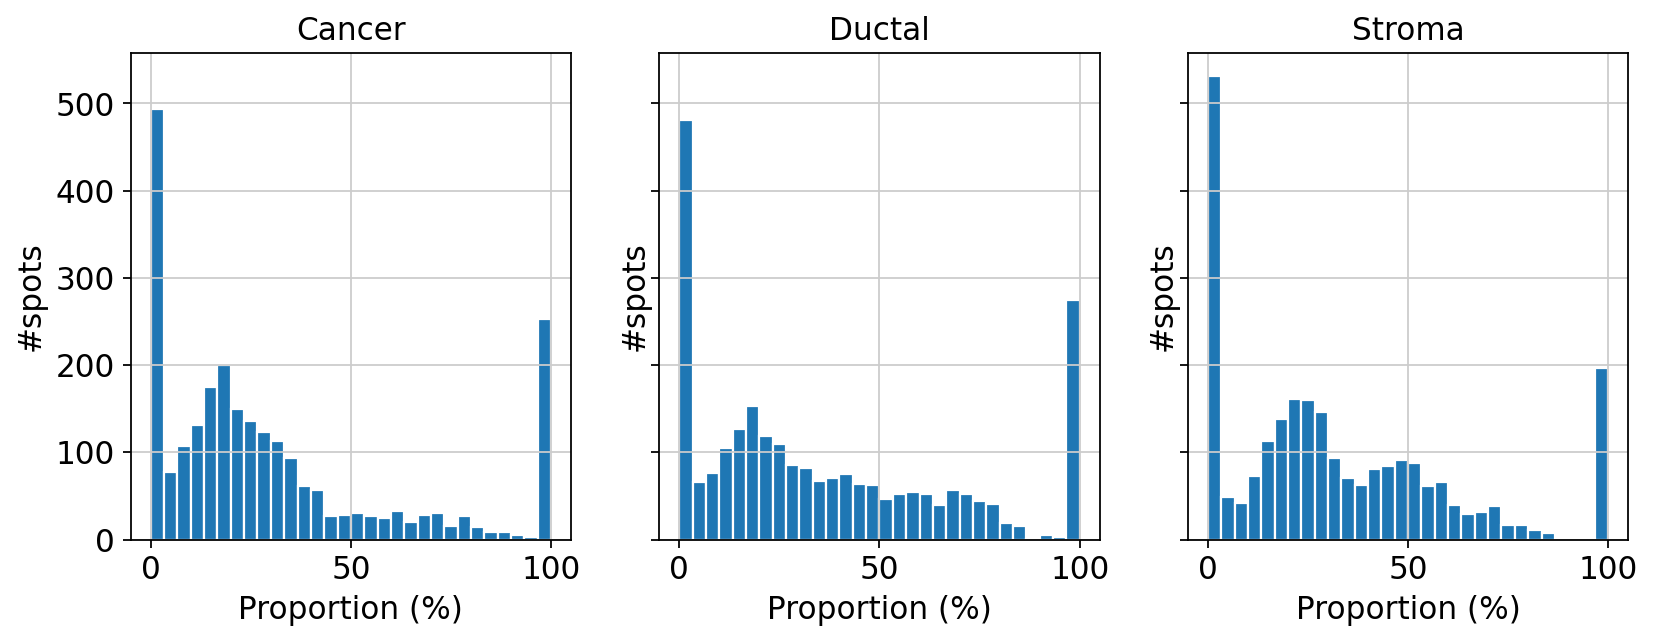

In [13]:
f, axs = plt.subplots(1,3, figsize=(12, 4), sharey=True)
sns.set_style("white")
for i in range(3):
    axs[i].hist(np.ravel(mat1[:,:,i] * 100), bins=30);
    axs[i].set_title(["Cancer", "Ductal", "Stroma"][i])
    axs[i].set_xlabel("Proportion (%)")
    axs[i].set_ylabel("#spots")
#f.savefig("Supp_Fig_simulated_prop_histogram.png", dpi=100)

In [16]:
### Function to sample counts from cell counts
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import trange
from time import time
from scipy.sparse import csr_matrix
from multiprocessing import Pool

def sample_counts(param):
    cell_counts, spot_id, frac, k = param
    np.random.seed(k)
    cts = cell_counts.index.tolist()
    all_reads = []
    genes = ref.var.index.tolist()
    
    for ct in cts:
        # sample cells from the same cell type
        nct = cell_counts[ct]
        cells_ct = ref.obs.index[ref.obs.CT == ct].tolist()
        cells = np.random.choice(cells_ct, nct, replace=False)
        # sample reads from each cell
        for cell in cells:
            vals = np.ravel(ref[cell, :].X).astype("int64")
            reads = np.repeat(genes, vals) # make gene counts as reads
            sampled_reads = list(np.random.choice(reads, int(frac * len(reads)), replace=False)) # sample reads
            all_reads += sampled_reads
    
    gvals = np.zeros((1, len(genes)))
    
    for j in range(len(genes)):
        gene = genes[j]
        gvals[0, j] = all_reads.count(gene)

    cell_props = (cell_counts / np.sum(cell_counts)).tolist()
    
    sampled_data = ad.AnnData(X=csr_matrix(gvals), var=ref.var, 
                              obs=pd.DataFrame(data=[[spot_id] + list(cell_counts.values) + cell_props],
                              columns= ['spot_id'] + cts + [f'prop_{ct}' for ct in cts],index=[spot_id]))
    return sampled_data

In [17]:
import warnings
warnings.filterwarnings("ignore")
frac=0.2 # fraction of read to be downsampled from each cell
ref = scRefA_filt.raw.to_adata()
spots = simulated_meta1.index.tolist()
params = [(simulated_meta1.iloc[j,:], spots[j], frac, j)  for j in range(simulated_meta1.shape[0])]
p = Pool(20)
mixture1 = p.map(sample_counts, params)
mixture1 = ad.concat(mixture1, join='outer')
mixture1.obs_names_make_unique()
p.close()
#mixture1.write(f'{prjDir}/pure/simulated_mixture.h5')

In [15]:
def add_infiltraion(simulated_pure_regions, mode='cancer_inf', prop=0.1, width = 15, length=10):
    np.random.seed(2021)
    simulated_with_infilt = simulated_pure_regions.copy()
    
    pure_cancer_spots = simulated_pure_regions.loc[(simulated_pure_regions.Ductal == 0) &\
                                                   (simulated_pure_regions.Stroma==0)].index.to_numpy()
    n = len(pure_cancer_spots)
    infiltration_spots = np.random.choice(pure_cancer_spots,int(prop * n), replace=False)

    ps = np.random.normal(loc=0.5, scale=0.2, size=len(infiltration_spots))
    ps[ps > 1] = 1
    ps[ps < 0] = 0

    for i, spot in enumerate(infiltration_spots):
        cancer_cell_count = simulated_pure_regions.loc[spot, 'Cancer']
        inf_num = int(ps[i] * cancer_cell_count)
        simulated_with_infilt.loc[spot, 'Stroma'] = inf_num
        simulated_with_infilt.loc[spot, 'Cancer'] = cancer_cell_count - inf_num

    simulated_with_infilt = simulated_with_infilt.loc[infiltration_spots,:]
    return simulated_with_infilt

In [16]:
inf_spots1 = add_infiltraion(simulated_meta1,  mode='cancer_inf', prop=0.1)
inf_cell_counts = simulated_meta1.copy()
inf_cell_counts.loc[inf_spots1.index,:] = inf_spots1.values
# inf_cell_counts.to_csv(f"{prjDir}/simulated_data/primary/infiltrated/simulated_spot_counts_ground_truth.csv"")
# inf_cell_counts = pd.read_csv(f"{prjDir}/simulated_data/primary/infiltrated/simulated_spot_counts_ground_truth.csv", index_col=0)
frac=0.2
ref = scRefA_filt.raw.to_adata()
spots = inf_cell_counts.index.tolist()
params = [(inf_cell_counts.iloc[j,:], spots[j], frac, j)  for j in range(inf_cell_counts.shape[0])]
mixture_with_infilt = ad.concat(mixture_with_infilt, join='outer')
mixture_with_infilt.obs_names_make_unique()
#mixture_with_infilt.write(f'{prjDir}/infiltrated/simulated_mixture.h5')

In [3]:
inf_cell_counts = pd.read_csv(f"{prjDir}/simulated_data/primary/infiltrated/simulated_spot_counts_ground_truth.csv", index_col=0)

  0%|          | 0/2500 [00:00<?, ?it/s]

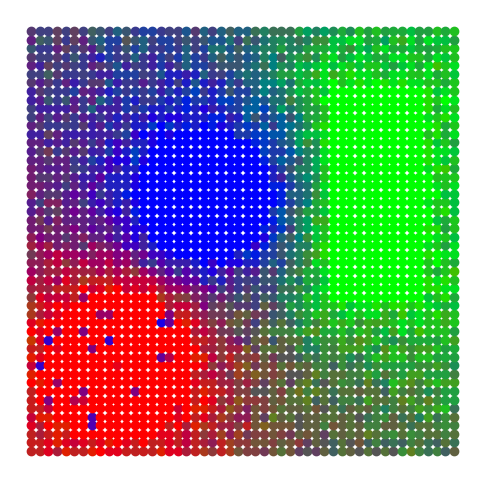

In [7]:
## Visualize infiltration
inf_patterns = inf_cell_counts.divide(inf_cell_counts.sum(axis=1), axis=0)
xs = [int(i.split("x")[0]) for i in inf_patterns.index.tolist()]
ys = [int(i.split("x")[1]) for i in inf_patterns.index.tolist()]
f = plt.figure(figsize=(6,6))
for i in trange(len(xs)):
    c = inf_patterns.values[i]
    plt.scatter(xs[i], ys[i], c=[c])
plt.axis("off")
plt.savefig("Supp-Fig2a-simulated-patterns-with-infilt.png", dpi=100, bbox_inches='tight')